In [2]:
import os
import time
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
from sklearn.cluster import KMeans
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import datetime
from datetime import datetime as dt

import random

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout, Conv2D, Flatten

import matplotlib.pyplot as plt

In [3]:
filepath = './horizontal/Video-15-47-49-515-31-03-2022/Video-15-47-49-515 (4IIC).mp4'
filepath_check = './checkpoint/'
input_dim = 500
maxCorners = 500
frames = 10
net_len = 1000
units = 100
output_size = 2
classes_list = ["stop", "move"]

In [4]:
horizontal = ['./horizontal/Video-7-36-30-868-22-03-2022/Video-7-36-30-868 (S1WK)',
            './horizontal/Video-10-6-45-47-30-03-2022/Video-10-6-45-47 (J57V)',
            './horizontal/Video-15-43-13-884-22-03-2022/Video-15-43-13-884 (J4NP)',
            './horizontal/Video-10-25-45-905-31-03-2022/Video-10-25-45-905 (3W3K)',
            './horizontal/Video-10-56-13-801-31-03-2022/Video-10-56-13-801 (X0N9)',            
            './horizontal/Video-11-19-18-132-30-03-2022/Video-11-19-18-132 (SH2G)',
            './horizontal/Video-12-51-53-673-27-03-2021/Video-12-51-53-673 (NKXJ)',
            './horizontal/Video-15-26-20-118-29-03-2022/Video-15-26-20-118 (5FLZ)',
            './horizontal/Video-15-32-33-709-31-03-2022/Video-15-32-33-709 (7BAA)',
            './horizontal/Video-15-41-30-94-29-03-2022/Video-15-41-30-94 (PH33)',
            #'./horizontal/Video-15-47-49-515-31-03-2022/Video-15-47-49-515 (4IIC)',
            './horizontal/Video-15-49-30-274-29-03-2022/Video-15-49-30-274 (JP92)',
            './horizontal/Video-15-8-58-789-27-03-2022/Video-15-8-58-789 (SSQM)',
            './horizontal/Video-17-14-15-118-06-03-2021/Video-17-14-15-118 (PE9P)',
            './horizontal/Video-17-34-45-652-25-03-2021/Video-17-34-45-652 (BK89)',
            './horizontal/Video-17-44-40-74-06-03-2021/Video-17-44-40-74 (CLNF)',
            './horizontal/Video-7-51-44-763-22-03-2022/Video-7-51-44-763 (1QN6)',
            './horizontal/Video-8-6-54-707-22-03-2022/Video-8-6-54-707 (PKAY)']


vertical = [#'./vertical/Video-10-15-12-812-14-11-2020/Video-10-15-12-812 (2Y5M)',
           './vertical/Video-10-30-21-575-29-09-2021/Video-10-30-21-575 (UOM8)',
           #'./vertical/Video-11-21-2-419-13-09-2021/Video-11-21-2-419 (KVYG)',
           './vertical/Video-11-21-6-412-28-12-2020/Video-11-21-6-412 (JQQM)',
           './vertical/Video-11-36-12-363-28-09-2021/Video-11-36-12-363 (8119)',
           './vertical/Video-11-36-16-421-28-12-2020/Video-11-36-16-421 (PFAQ)',
           #'./vertical/Video-11-5-49-336-13-09-2021/Video-11-5-49-336 (CZPL)',
           './vertical/Video-12-23-51-640-02-10-2021/Video-12-23-51-640 (WLWK)',
           #'./vertical/Video-12-39-1-595-02-10-2021/Video-12-39-1-595 (QDUT)',
           #'./vertical/Video-12-44-36-682-24-09-2021/Video-12-44-36-682 (ATO6)',
           './vertical/Video-13-16-32-822-10-09-2021/Video-13-16-32-822 (UQ1Q)',
           './vertical/Video-13-20-30-695-15-11-2021/Video-13-20-30-695 (VLFO)',
           #'./vertical/Video-13-31-46-773-10-09-2021/Video-13-31-46-773 (MXM7)',
           #'./vertical/Video-16-16-44-458-17-11-2020/Video-16-16-44-458 (LCRL)',
           './vertical/Video-16-36-42-174-10-11-2020/Video-16-36-42-174 (IXTE)',
           './vertical/Video-16-47-10-870-17-11-2020/Video-16-47-10-870 (YFCN)',
           #'./vertical/Video-17-17-30-919-17-11-2020/Video-17-17-30-919 (ID6X)',
           #'./vertical/Video-17-32-40-752-17-11-2020/Video-17-32-40-752 (E575)',
           #'./vertical/Video-17-47-40-713-02-10-2021/Video-17-47-40-713 (E7IK)',
           './vertical/Video-20-21-59-727-24-09-2021/Video-20-21-59-727 (S04R)',
           './vertical/Video-20-45-56-152-24-10-2021/Video-20-45-56-152 (6M38)']

random.shuffle(horizontal)
random.shuffle(vertical)

videopath = horizontal# + vertical

random.shuffle(videopath)

In [5]:
checkpoint = keras.callbacks.ModelCheckpoint(
        filepath_check, monitor="val_accuracy",
        save_best_only=True, verbose=1,
        mode='max')
callbacks = [checkpoint]

In [7]:
def real_time(video_path, model, callbacks):  
    # Read the video 
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_BUFFERSIZE, 2)
    # Parameters for ShiTomasi corner detection
    feature_params = dict(maxCorners = maxCorners,
                       qualityLevel = 0.07,
                       minDistance = 7,
                       blockSize = 7)

    # Parameters for Lucas Kanade optical flow
    lk_params = dict(winSize  = (15, 15),
                  maxLevel = 3,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
    
    color = np.random.randint(0, 255, (500, 3))
    plt = []
    labels = []
    median_class_name = ' '
    network_class_name = ' '
    
    while True:       
        # Take first frame and find corners in it
        ret, old_frame = cap.read()
        if not ret:
            break
            
        old_frame = cv2.resize(old_frame, (input_dim, input_dim))        
        
        old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)        
                
        p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)

        # Create a mask image for drawing purposes
        mask = np.zeros_like(old_frame)        
        
        median_list_l = []
        median_list_r = []
        network_frame = []
        model_data = []
        while True:
            # Read new frame
            ret, frame = cap.read()
            
            if not ret:
                break
            frame = cv2.resize(frame, (input_dim, input_dim))
            
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            # Calculate Optical Flow
            p1, st, err = cv2.calcOpticalFlowPyrLK(
                old_gray, frame_gray, p0, None, **lk_params
            )
            
            if p1 is None:
                break

            # Select good points
            good_new = p1[st == 1]
            good_old = p0[st == 1]
            #print(good_new)
            new_net_l = np.array([])
            new_net_r = np.array([])
            for i in range(len(good_new)):
                if good_new[i][0] < input_dim/2:
                    if len(new_net_l) == 0:
                        new_net_l = np.array([good_new[i] - good_old[i]])
                    else:
                        new_net_l = np.append(new_net_l, [good_new[i] - good_old[i]], axis=0)
                else:
                    if len(new_net_r) == 0:
                        new_net_r = np.array([good_new[i] - good_old[i]])
                    else:
                        new_net_r = np.append(new_net_r, [good_new[i] - good_old[i]], axis=0)
                       
            # Draw the tracks
            for i, (new, old) in enumerate(zip(good_new, good_old)):
                a, b = new.ravel()
                c, d = old.ravel()
                #mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), color[i].tolist(), 2)
                #frame = cv2.circle(frame, (int(a), int(b)), 5, color[i].tolist(), -1)
 
            mask_med = np.zeros_like(old_frame)
            if new_net_l.shape[0] != 0:
                median_frame_x_l = input_dim/4 + np.median(new_net_l[:, 0])*80  
                median_frame_y_l = input_dim/2 + np.median(new_net_l[:, 1])*80
                mask_med = cv2.line(mask_med, (int(input_dim/4), int(input_dim/2)),
                                (int(median_frame_x_l), int(median_frame_y_l)), (0, 0, 255), 3)
                median_frame_l_x = np.median(np.absolute(new_net_l[:, 0]))
                median_frame_l_y = np.median(np.absolute(new_net_l[:, 1]))
                median_list_l.append([median_frame_l_x,median_frame_l_y])
            
            if new_net_r.shape[0] != 0:
                median_frame_x_r = 3*input_dim/4 + np.median(new_net_r[:, 0])*80  
                median_frame_y_r = input_dim/2 + np.median(new_net_r[:, 1])*80
                mask_med = cv2.line(mask_med, (int(3*input_dim/4), int(input_dim/2)),
                                (int(median_frame_x_r), int(median_frame_y_r)), (0, 0, 255), 3)        
                median_frame_r_x = np.median(np.absolute(new_net_r[:, 0]))
                median_frame_r_y = np.median(np.absolute(new_net_r[:, 1]))
                median_list_r.append([median_frame_r_x,median_frame_r_y])
                
            img = cv2.add(frame, mask_med)
            #img = cv2.add(img, mask_med)
            
            model_data.append(np.array([median_frame_l_x,median_frame_r_x, median_frame_l_y, median_frame_r_y])/input_dim)

            
            cv2.putText(img, median_class_name, 
                        (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            
            cv2.putText(img, network_class_name + '(network)', 
                        (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
                        
            cv2.imshow("frame", img)
            k = cv2.waitKey(15) & 0xFF
            if k == 27:
                break
            plt.append(np.array([median_frame_l_x,median_frame_r_x, median_frame_l_y, median_frame_r_y])/input_dim)  
            
            # Update the previous frame and previous points
            old_gray = frame_gray.copy()
            p0 = good_new.reshape(-1, 1, 2)
            if np.array(median_list_r).shape[0] >= frames:                
                median_l = np.median(median_list_l) 
                if median_l >= 0.09 and median_l <= 30:
                    median_class_name_l = 1
                else:
                    median_class_name_l = 0
                                                    
                median_r = np.median(median_list_r) 
                if median_r >= 0.09 and median_r <= 30:
                    median_class_name_r = 1
                else:
                    median_class_name_r = 0
                    
                label = 0   
                if median_class_name_r == 1 and median_class_name_l == 1:
                    median_class_name = classes_list[1]
                    label = 1
                else:
                    median_class_name = classes_list[0]
                    label = 0
                    
                predicted_labels_probabilities = model.predict(np.array(model_data),callbacks=callbacks)
                network_class_name = classes_list[np.argmax([np.median(np.array(predicted_labels_probabilities)[:,0]),
                                                            np.median(np.array(predicted_labels_probabilities)[:,1])])]
                
                for i in range(frames):
                    labels.append(np.array([label]))   
                    
                    
                break
    return plt, labels

In [8]:
#Возвращает данные о движении пикселей, состояния с порога и состояния с нейронной сети 
def data_model(video_path, model, callbacks):  
    # Read the video 
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_BUFFERSIZE, 2)
    # Parameters for ShiTomasi corner detection
    feature_params = dict(maxCorners = maxCorners,
                       qualityLevel = 0.07,
                       minDistance = 7,
                       blockSize = 7 )

    # Parameters for Lucas Kanade optical flow
    lk_params = dict(winSize  = (15, 15),
                  maxLevel = 3,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
    

    plt = []
    labels = []
    model_labels = [] 
    network_class_name = 0 
    label = 0
    while True:       
        # Take first frame and find corners in it
        ret, old_frame = cap.read()
        if not ret:
            break
            
        old_frame = cv2.resize(old_frame, (input_dim, input_dim))        
        
        old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)        
                
        p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)

        # Create a mask image for drawing purposes
        mask = np.zeros_like(old_frame)        
        
        median_list_l = []
        median_list_r = []
        network_frame = []
        model_data = []
        while True:
            # Read new frame
            ret, frame = cap.read()
            
            if not ret:
                break
            frame = cv2.resize(frame, (input_dim, input_dim))
            
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            # Calculate Optical Flow
            p1, st, err = cv2.calcOpticalFlowPyrLK(
                old_gray, frame_gray, p0, None, **lk_params
            )
            
            if p1 is None:
                break

            # Select good points
            good_new = p1[st == 1]
            good_old = p0[st == 1]
            
            new_net_l = np.array([])
            new_net_r = np.array([])
            for i in range(len(good_new)):
                if good_new[i][0] < input_dim/2:
                    if len(new_net_l) == 0:
                        new_net_l = np.array([good_new[i] - good_old[i]])
                    else:
                        new_net_l = np.append(new_net_l, [good_new[i] - good_old[i]], axis=0)
                else:
                    if len(new_net_r) == 0:
                        new_net_r = np.array([good_new[i] - good_old[i]])
                    else:
                        new_net_r = np.append(new_net_r, [good_new[i] - good_old[i]], axis=0)
                       
 
            mask_med = np.zeros_like(old_frame)
            if new_net_l.shape[0] != 0:
                median_frame_l_x = np.median(np.absolute(new_net_l[:, 0]))
                median_frame_l_y = np.median(np.absolute(new_net_l[:, 1]))
                median_list_l.append([median_frame_l_x,median_frame_l_y])
            
            if new_net_r.shape[0] != 0:       
                median_frame_r_x = np.median(np.absolute(new_net_r[:, 0]))
                median_frame_r_y = np.median(np.absolute(new_net_r[:, 1]))
                median_list_r.append([median_frame_r_x,median_frame_r_y])
                            
            model_data.append(np.array([median_frame_l_x,median_frame_r_x, median_frame_l_y, median_frame_r_y])/input_dim)

            plt.append(np.array([median_frame_l_x,median_frame_r_x, median_frame_l_y, median_frame_r_y])/input_dim)
            labels.append(label)
            model_labels.append(network_class_name)
            
            # Update the previous frame and previous points
            old_gray = frame_gray.copy()
            p0 = good_new.reshape(-1, 1, 2)
            
            if np.array(median_list_r).shape[0] >= frames:                
                median_l = np.median(median_list_l) 
                if median_l >= 0.09 and median_l <= 30:
                    median_class_name_l = 1
                else:
                    median_class_name_l = 0
                                                    
                median_r = np.median(median_list_r) 
                if median_r >= 0.09 and median_r <= 30:
                    median_class_name_r = 1
                else:
                    median_class_name_r = 0
                    
                label = 0   
                if median_class_name_r == 1 and median_class_name_l == 1:
                    label = 1
                else:
                    label = 0
                    
                predicted_labels_probabilities = model.predict(np.array(model_data),callbacks=callbacks)
                network_class_name = np.argmax([np.median(np.array(predicted_labels_probabilities)[:,0]),
                                                np.median(np.array(predicted_labels_probabilities)[:,1])])
                break
                
    return plt, labels, model_labels

In [9]:
#Возвращает данные о движении пикселей и состояния с порога
def data(video_path):  
    # Read the video 
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_BUFFERSIZE, 2)
    # Parameters for ShiTomasi corner detection
    feature_params = dict(maxCorners = maxCorners,
                       qualityLevel = 0.07,
                       minDistance = 7,
                       blockSize = 7 )

    # Parameters for Lucas Kanade optical flow
    lk_params = dict(winSize  = (15, 15),
                  maxLevel = 3,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
    
    plt = []
    labels = []
    median_class_name = ' '
    label = 0
    while True:       
        # Take first frame and find corners in it
        ret, old_frame = cap.read()
        if not ret:
            break
            
        old_frame = cv2.resize(old_frame, (input_dim, input_dim))        
        
        old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)        
                
        p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)

        # Create a mask image for drawing purposes
        mask = np.zeros_like(old_frame)        
        
        median_list_l = []
        median_list_r = []
        
        while True:
            # Read new frame
            ret, frame = cap.read()
            
            if not ret:
                break
            frame = cv2.resize(frame, (input_dim, input_dim))
            
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            # Calculate Optical Flow
            p1, st, err = cv2.calcOpticalFlowPyrLK(
                old_gray, frame_gray, p0, None, **lk_params
            )
            
            if p1 is None:
                break

            # Select good points
            good_new = p1[st == 1]
            good_old = p0[st == 1]
            #print(good_new)
            new_net_l = np.array([])
            new_net_r = np.array([])
            for i in range(len(good_new)):
                if good_new[i][0] < input_dim/2:
                    if len(new_net_l) == 0:
                        new_net_l = np.array([good_new[i] - good_old[i]])
                    else:
                        new_net_l = np.append(new_net_l, [good_new[i] - good_old[i]], axis=0)
                else:
                    if len(new_net_r) == 0:
                        new_net_r = np.array([good_new[i] - good_old[i]])
                    else:
                        new_net_r = np.append(new_net_r, [good_new[i] - good_old[i]], axis=0)
 
            mask_med = np.zeros_like(old_frame)
            if new_net_l.shape[0] != 0:
                median_frame_l_x = np.median(np.absolute(new_net_l[:, 0]))
                median_frame_l_y = np.median(np.absolute(new_net_l[:, 1]))
                median_list_l.append([median_frame_l_x,median_frame_l_y])
            else:
                median_list_l.append([0,0])
            
            if new_net_r.shape[0] != 0:       
                median_frame_r_x = np.median(np.absolute(new_net_r[:, 0]))
                median_frame_r_y = np.median(np.absolute(new_net_r[:, 1]))
                median_list_r.append([median_frame_r_x,median_frame_r_y])
            else:
                median_list_r.append([0,0])
    
            
            plt.append(np.array([median_frame_l_x,median_frame_r_x, median_frame_l_y, median_frame_r_y])/input_dim)  
            labels.append(np.array([label])) 
            # Update the previous frame and previous points
            old_gray = frame_gray.copy()
            p0 = good_new.reshape(-1, 1, 2)
            if np.array(median_list_r).shape[0] >= frames:                
                median_l = np.median(median_list_l) 
                if median_l >= 0.09 and median_l <= 30:
                    median_class_name_l = 1
                else:
                    median_class_name_l = 0
                                                    
                median_r = np.median(median_list_r) 
                if median_r >= 0.09 and median_r <= 30:
                    median_class_name_r = 1
                else:
                    median_class_name_r = 0
                    
                label = 0   
                if median_class_name_r == 1 and median_class_name_l == 1:
                    median_class_name = classes_list[1]
                    label = 1
                else:
                    median_class_name = classes_list[0]
                    label = 0
                break
    return plt, labels
    #video_writer.release()

In [11]:
def get_CNN(units, input_dim, output_size): 
    model = keras.Sequential()
    model.add(Input((4,)))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(8, activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(4, activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(2, activation='softmax'))
    
    
    return model

In [24]:
def get_RNN(units, output_size):
    model = keras.Sequential()
    model.add(layers.LSTM(units, return_sequences=True, input_shape=(4)))
    model.add(layers.GRU(64))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(32, activation="relu"))
    model.add(layers.Dense(output_size))

    return model

In [23]:
# Adding Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_accuracy', patience = 15,
                                        mode = 'max', restore_best_weights = True)

model = get_CNN(8, 4, 2)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

In [65]:
x = np.array([])
y = np.array([])
j = 0 
for i in vertical:  
    j += 1
    print(j, i)
    x_i, y_i = data(i + '.mp4')
    if j == 1:
        x = x_i
        y = y_i
    else:
        x = np.concatenate((x, x_i), 0)
        y = np.concatenate((y, y_i), 0)
        
      

1 ./vertical/Video-20-21-59-727-24-09-2021/Video-20-21-59-727 (S04R)
2 ./vertical/Video-11-36-16-421-28-12-2020/Video-11-36-16-421 (PFAQ)
3 ./vertical/Video-10-30-21-575-29-09-2021/Video-10-30-21-575 (UOM8)
4 ./vertical/Video-13-16-32-822-10-09-2021/Video-13-16-32-822 (UQ1Q)
5 ./vertical/Video-12-23-51-640-02-10-2021/Video-12-23-51-640 (WLWK)
6 ./vertical/Video-13-20-30-695-15-11-2021/Video-13-20-30-695 (VLFO)
7 ./vertical/Video-20-45-56-152-24-10-2021/Video-20-45-56-152 (6M38)


UnboundLocalError: local variable 'median_frame_r_x' referenced before assignment

In [53]:
np.save('x', x)
np.save('y', y)

In [50]:
val_x = np.load('./processed/val_x.npy')
val_y = np.load('./processed/val_y.npy')

In [59]:
x_ver = np.load('./processed/ver/x.npy')
y_ver = np.load('./processed/ver/y.npy')

In [60]:
x_hor = np.load('./processed/hor/x.npy')
y_hor = np.load('./processed/hor/y.npy')

In [61]:
x = np.concatenate((x_ver, x_hor), 0)
y = np.concatenate((y_ver, y_hor), 0)

In [15]:
model.load_weights('./weights/my_checkpoint')

In [62]:
model.fit(
        x, y, batch_size=1000, epochs=15,
        callbacks = callbacks,
        validation_data  = (val_x, val_y),
        shuffle = True 
)

model.save_weights('./weights/my_checkpoint')

Epoch 1/15
552/556 [============================>.] - ETA: 0s - loss: 0.1640 - accuracy: 0.9397
Epoch 1: val_accuracy did not improve from 0.97921
556/556 [==============================] - 2s 4ms/step - loss: 0.1639 - accuracy: 0.9397 - val_loss: 0.4332 - val_accuracy: 0.7796
Epoch 2/15
543/556 [============================>.] - ETA: 0s - loss: 0.1639 - accuracy: 0.9399
Epoch 2: val_accuracy did not improve from 0.97921
556/556 [==============================] - 2s 4ms/step - loss: 0.1639 - accuracy: 0.9398 - val_loss: 0.4239 - val_accuracy: 0.8460
Epoch 3/15
546/556 [============================>.] - ETA: 0s - loss: 0.1633 - accuracy: 0.9407
Epoch 3: val_accuracy did not improve from 0.97921
556/556 [==============================] - 2s 4ms/step - loss: 0.1634 - accuracy: 0.9406 - val_loss: 0.1768 - val_accuracy: 0.9523
Epoch 4/15
543/556 [============================>.] - ETA: 0s - loss: 0.1630 - accuracy: 0.9405
Epoch 4: val_accuracy did not improve from 0.97921
556/556 [==========

In [ ]:
val_x, val_y = data('./horizontal/Video-15-47-49-515-31-03-2022/Video-15-47-49-515 (4IIC).mp4')

In [ ]:
np.save('val_x', val_x)
np.save('val_y', val_y)

In [ ]:
val_x = np.array(val_x)
val_y = np.array(val_y)
print(val_x.shape, val_y.shape)

In [86]:
tx, ty = data('./horizontal/Video-15-47-49-515-31-03-2022/Video-15-47-49-515 (4IIC).mp4')

In [ ]:
plt.plot(range(tx.shape[0]), ty)
plt.plot(range(tx.shape[0]), ty/9)
plt.figure(figsize=(20, 10))
plt.show()

In [16]:
p2, l2 = real_time('./horizontal/Video-15-47-49-515-31-03-2022/Video-15-47-49-515 (4IIC).mp4', model, callbacks)


KeyboardInterrupt: 

In [34]:
med_4, labels, model_labels = data_model('./horizontal/Video-15-47-49-515-31-03-2022/Video-15-47-49-515 (4IIC).mp4', model, callbacks)

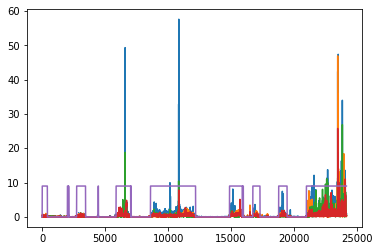

<Figure size 1440x720 with 0 Axes>

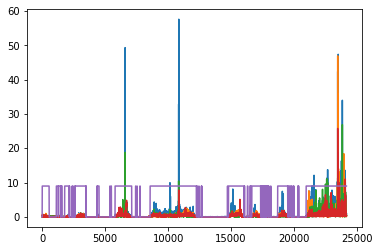

<Figure size 1440x720 with 0 Axes>

In [47]:
num = np.array(med_4).shape[0]
plt.plot(range(num), med_4)
plt.plot(range(num), np.array(labels)*9)
#plt.plot(range(num), np.array(model_labels)*9)
plt.figure(figsize=(20, 10))
plt.show()

plt.plot(range(num), med_4)
#plt.plot(range(num), np.array(labels)*9)
plt.plot(range(num), np.array(model_labels)*9)
plt.figure(figsize=(20, 10))
plt.show()